In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

## Data Preparation

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,276,128,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,264,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,287,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,264,117,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   klasifikasi_perkara_encoded     4323 non-null   int64  
 1   penuntut_umum_encoded           4323 non-null   int64  
 2   hakim_encoded                   4323 non-null   int64  
 3   jumlah_saksi                    4323 non-null   int64  
 4   maks_penjara_berdasarkan_pasal  4323 non-null   int64  
 5   terdakwa                        4323 non-null   object 
 6   summarized_dakwaan              4323 non-null   object 
 7   total_pidana_penjara_bulan      4323 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 270.3+ KB


### Split Data

In [5]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [6]:
train_df, test_df = stratified_split(df)

{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 37): [1051], (0, 21, 55): [1612], (0, 21, 57): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

C:\Users\Kalea\AppData\Local\Temp\ipykernel_10448\635274658.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()


In [7]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Train:  3273
klasifikasi_perkara_encoded
0    1378
2    1251
3     289
4     193
1     162
Name: count, dtype: int64


In [8]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Test:  1050
klasifikasi_perkara_encoded
0    490
2    438
4     51
3     48
1     23
Name: count, dtype: int64


## Model

### Model Preprocessing

In [9]:
train_df['concat_text'] = train_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)
test_df['concat_text'] = test_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)

In [10]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

### Normalisasi

In [11]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['normalized_text'] = train_df['concat_text'].apply(normalize_text)
test_df['normalized_text'] = test_df['concat_text'].apply(normalize_text)

### Stopwords Removal

In [12]:
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['stopword_removal'] = train_df['normalized_text'].apply(remove_stopwords)
test_df['stopword_removal'] = test_df['normalized_text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kalea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Stemming

In [13]:
stemmer = PorterStemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

train_df['stemmed_text'] = train_df['stopword_removal'].apply(stem_text)
test_df['stemmed_text'] = test_df['stopword_removal'].apply(stem_text)

### Tokenizer

In [14]:
# Tokenisasi
tokenizer = tf.keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(train_df['stemmed_text'])
train_sequences = tokenizer.texts_to_sequences(train_df['stemmed_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['stemmed_text'])

In [15]:
vocab_size = len(tokenizer.word_index) + 1  # 4 + 1 = 5
print("Vocabulary size:", vocab_size)

Vocabulary size: 14906


In [16]:
# Padding
# max_len = max(len(seq) for seq in train_sequences)
max_len = 1024
X_train_texts = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_texts = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [17]:
print(max_len)

1024


### Numerical Features

In [18]:
# TANPA LOG TRANSFORM (gunakan salah satu)

train_numerical = tf.constant(train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)
test_numerical = tf.constant(test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)

## Saved Model Inference

In [19]:
model_scenario_name = "BiLSTM_13"
max_len = 1024

model_save_path = f'../Model/{model_scenario_name}'
tokenizer_save_path = f'../Model/{model_scenario_name}_tokenizer.pkl'
history_training_save_path = f'../Model/{model_scenario_name}_training_history.pkl'
    
loaded_model = tf.keras.models.load_model(model_save_path)

with open(tokenizer_save_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [20]:
# Buat model embedding: token integer -> embedding float
input_text_new = tf.keras.Input(shape=(1024,), dtype=tf.int32, name='text_input_new')
embedding_layer = loaded_model.get_layer('embedding')
embedding_output = embedding_layer(input_text_new)
embedding_model = tf.keras.Model(inputs=input_text_new, outputs=embedding_output)

# Buat input baru: embedding dan numeric
input_embed = tf.keras.Input(shape=(1024, 256), name='embedding_input')
input_num = tf.keras.Input(shape=(5,), name='numeric_input')

# Rekonstruksi bagian setelah embedding
x = loaded_model.get_layer('bidirectional')(input_embed)
x = loaded_model.get_layer('batch_normalization')(x)
x = loaded_model.get_layer('bidirectional_1')(x)
x = loaded_model.get_layer('batch_normalization_1')(x)
x = loaded_model.get_layer('bidirectional_2')(x)
x = loaded_model.get_layer('batch_normalization_2')(x)
x = loaded_model.get_layer('global_max_pooling1d')(x)
x = loaded_model.get_layer('dropout')(x)

n = loaded_model.get_layer('batch_normalization_3')(input_num)
n = loaded_model.get_layer('dense')(n)
n = loaded_model.get_layer('dense_1')(n)
n = loaded_model.get_layer('dense_2')(n)

concat = loaded_model.get_layer('concatenate')([x, n])
concat = loaded_model.get_layer('batch_normalization_4')(concat)
concat = loaded_model.get_layer('dense_3')(concat)
concat = loaded_model.get_layer('dropout_1')(concat)
concat = loaded_model.get_layer('dense_4')(concat)
output = loaded_model.get_layer('dense_5')(concat)

# Final model: menerima embedding float dan numeric float
new_model = tf.keras.Model(inputs=[input_embed, input_num], outputs=output)


In [ ]:

# Fungsi integrated gradients input embedding float dan numerik float
def integrated_gradients_embedding(model, embedding_input, numeric_input, baseline_embed=None, baseline_num=None, m_steps=50):
    if baseline_embed is None:
        baseline_embed = tf.zeros_like(embedding_input)
    if baseline_num is None:
        baseline_num = tf.zeros_like(numeric_input)

    delta_embed = embedding_input - baseline_embed
    delta_num = numeric_input - baseline_num

    total_grads_embed = tf.zeros_like(embedding_input, dtype=tf.float32)
    total_grads_num = tf.zeros_like(numeric_input, dtype=tf.float32)

    alphas = tf.linspace(0.0, 1.0, m_steps)

    for alpha in alphas:
        interpolated_embed = baseline_embed + alpha * delta_embeds
        interpolated_num = baseline_num + alpha * delta_num

        with tf.GradientTape() as tape:
            tape.watch([interpolated_embed, interpolated_num])
            preds = model([interpolated_embed, interpolated_num], training=False)

        grads = tape.gradient(preds, [interpolated_embed, interpolated_num])

        total_grads_embed += grads[0]
        total_grads_num += grads[1]

    avg_grads_embed = total_grads_embed / tf.cast(m_steps, tf.float32)
    avg_grads_num = total_grads_num / tf.cast(m_steps, tf.float32)

    integrated_grad_embed = delta_embed * avg_grads_embed
    integrated_grad_num = delta_num * avg_grads_num

    return integrated_grad_embed, integrated_grad_num

In [22]:
integrated_gradient_results = {}

In [ ]:

for i in tqdm(range(2)):
    sample_text_int = tf.constant([X_test_texts[i]], dtype=tf.int32)
    embedding_float = embedding_model(sample_text_int)
    
    numeric_tensor = tf.reshape(test_numerical[i], (1, 5))

    ig_text, ig_numeric = integrated_gradients_embedding(new_model, embedding_float, numeric_tensor)

    if 'ig_text' not in integrated_gradient_results:
        integrated_gradient_results['ig_text'] = []

    if 'ig_numeric' not in integrated_gradient_results:
        integrated_gradient_results['ig_numeric'] = []

    integrated_gradient_results['ig_text'].append(ig_text)
    integrated_gradient_results['ig_numeric'].append(ig_numeric)


100%|██████████| 2/2 [00:28<00:00, 14.45s/it]


In [ ]:
integrated_gradient_results['ig_text'][0]

<tf.Tensor: shape=(1, 1024, 256), dtype=float32, numpy=
array([[[ 0.00166553, -0.00234442, -0.01979942, ...,  0.01235048,
         -0.0003139 ,  0.00795461],
        [-0.00508114, -0.00472526,  0.03537938, ..., -0.02934348,
         -0.01209802, -0.01111266],
        [-0.01204939, -0.00482614, -0.04510731, ...,  0.01224615,
         -0.00313737,  0.00533535],
        ...,
        [-0.07040261, -0.01166124, -0.00489176, ...,  0.00033643,
         -0.01249446, -0.00854866],
        [-0.06783876, -0.01297285, -0.01237331, ...,  0.0019252 ,
         -0.01782111, -0.01126682],
        [-0.05558699, -0.01332043, -0.0119473 , ...,  0.00613283,
         -0.02115708, -0.01609387]]], dtype=float32)>

In [25]:
# Simpan ke file
with open('integrated_gradient_results.pkl', 'wb') as f:
    pickle.dump(integrated_gradient_results, f)

# Untuk load kembali
with open('integrated_gradient_results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

In [26]:
loaded_results['ig_numeric']

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.       , 0.       , 0.       , 1.5012991, 1.7499776]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.0000000e+00,  7.5903907e-04,  0.0000000e+00,  1.7256484e+00,
          3.8550782e-01]], dtype=float32)>]

In [27]:
ig_numeric = loaded_results['ig_numeric']

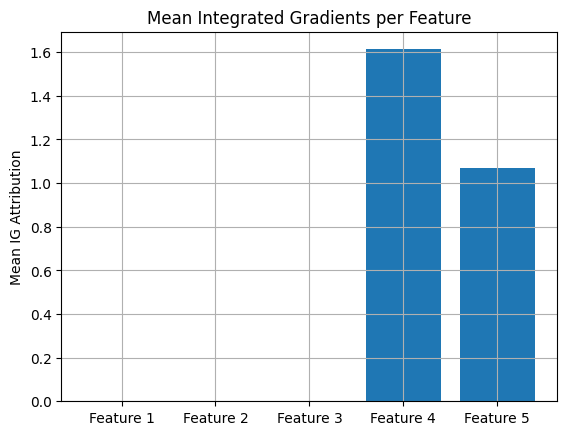

In [28]:
# Ensure ig_numeric is a NumPy array first
ig_array = np.array(ig_numeric)

# Reduce over axis 0 (samples) → shape: (5,)
mean_ig = np.mean(ig_array, axis=0)

# Squeeze in case it's accidentally 2D like (5, 1) or (1, 5)
mean_ig = np.squeeze(mean_ig)

# Ensure it's 1D and contains native floats
mean_ig = mean_ig.astype(float)

# Plot bar chart
plt.bar(range(len(mean_ig)), mean_ig)
plt.xticks(range(len(mean_ig)), [f'Feature {i+1}' for i in range(len(mean_ig))])
plt.ylabel('Mean IG Attribution')
plt.title('Mean Integrated Gradients per Feature')
plt.grid(True)
plt.show()

TypeError: only length-1 arrays can be converted to Python scalars

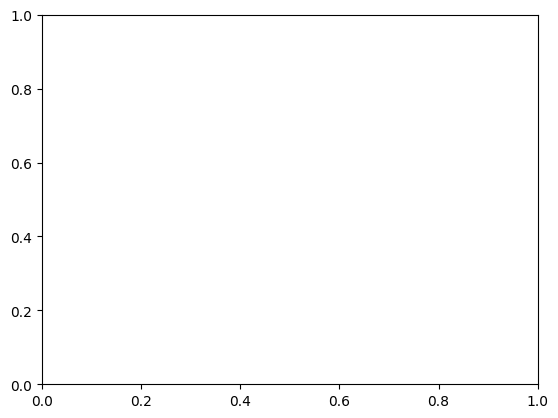

In [32]:
plt.bar(range(5), loaded_results['ig_numeric'])
plt.xlabel("Fitur numerik ke-i")
plt.ylabel("Kontribusi via IG")
plt.title("Sensitivitas Fitur Numerik")
plt.show()


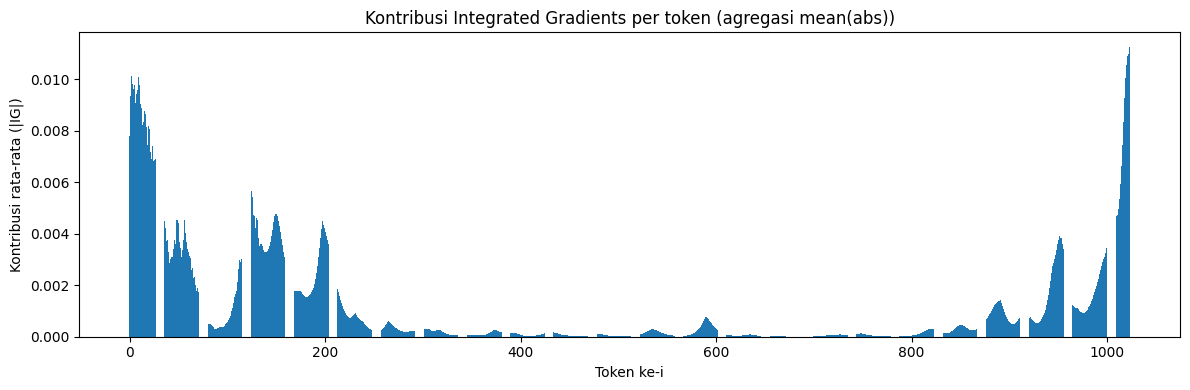

In [27]:

# Hitung skor kontribusi per token (agg dimensi embedding)
token_contributions = tf.reduce_mean(tf.abs(ig_text[0]), axis=-1).numpy()  # shape (1024,)

# Plot
plt.figure(figsize=(12, 4))
plt.bar(range(len(token_contributions)), token_contributions)
plt.xlabel("Token ke-i")
plt.ylabel("Kontribusi rata-rata (|IG|)")
plt.title("Kontribusi Integrated Gradients per token (agregasi mean(abs))")
plt.tight_layout()
plt.show()


In [ ]:

# Konversi ke token string
tokens = tokenizer.sequences_to_texts(sample_text_int.numpy())[0].split()
tokens = [tokenizer.index_word.get(id, '[UNK]') for id in ASAZ]


In [ ]:
# Hitung kontribusi rata-rata per token
token_contributions = tf.reduce_mean(tf.abs(ig_text[0]), axis=-1).numpy()

# Pangkas padding 
valid_tokens = [(t, c) for t, c in zip(tokens, token_contributions) if t != '[PAD]']
tokens_filtered, contribs_filtered = zip(*valid_tokens)

# Plot
plt.figure(figsize=(min(0.4 * len(tokens_filtered), 20), 4))
plt.bar(range(len(contribs_filtered)), contribs_filtered)
plt.xticks(range(len(tokens_filtered)), tokens_filtered, rotation=90)
plt.xlabel("Token")
plt.ylabel("Kontribusi rata-rata (|IG|)")
plt.title("Kontribusi IG per token")
plt.tight_layout()
plt.show()

In [ ]:
# Buang padding (misal id=0 dianggap padding)
filtered = [(t, c) for t, c in zip(tokens, token_contributions) if t != '[PAD]']

# Ambil 20 token dengan kontribusi terbesar
top_tokens = sorted(filtered, key=lambda x: x[1], reverse=True)[:20]

# Pisahkan kembali token dan kontribusinya
tokens_top, contribs_top = zip(*top_tokens)


In [ ]:
plt.figure(figsize=(12, 4))
plt.bar(range(len(contribs_top)), contribs_top)
plt.xticks(range(len(tokens_top)), tokens_top, rotation=45, ha='right')
plt.xlabel("Token")
plt.ylabel("Kontribusi rata-rata (|IG|)")
plt.title("20 Token Paling Berpengaruh menurut Integrated Gradients")
plt.tight_layout()
plt.show()